Loading IMDB data

In [1]:
!pip install tensorflow==2.12 #installing the 2.12 version because google colab uses this version

In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.getLogger('tensorflow').disabled = True

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras import preprocessing
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM,  Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import load_model
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from google.colab import files
import re, os

In [4]:
num_words = 10000
maxlen = 150

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
train_data = pad_sequences(train_data, maxlen=maxlen)
test_data = pad_sequences(test_data, maxlen=maxlen)


# Combining the Training and Testing data create an entire dataset
texts = np.concatenate((train_data, test_data), axis=0)
labels = np.concatenate((train_labels, test_labels), axis=0)

# Splitting the data into Training and Validation Samples
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, train_size=100, test_size=10000, random_state=42, stratify=labels)
# Further split the data to get the test size of 5000 samples
_, test_texts, _, test_labels = train_test_split(test_data, test_labels, test_size=5000, random_state=42, stratify=test_labels)


17464789/17464789 [==============================] - 0s 0us/step


Using an Embedding layer and classifier in IMDB data

In [5]:
model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 8)            80000     
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 1)                 1201      
                                                                 
Total params: 81,201
Trainable params: 81,201
Non-trainable params: 0
_________________________________________________________________


Number of Parameters

In [6]:
# Setting Callbacks
callbacks = ModelCheckpoint(
            filepath= "model1.h5",
            save_best_only= True,
            monitor= "val_loss"
            )


# Model Fit - Running the Model
# Assigning the fit method's return value to history for accessing training history later.
history = model.fit(train_texts, train_labels,
                    epochs=20,
                    batch_size=32,
                    validation_data=(val_texts, val_labels),
                    callbacks=callbacks)

Epoch 1/20
4/4 [==============================] - 2s 329ms/step - loss: 0.6961 - accuracy: 0.4300 - val_loss: 0.6939 - val_accuracy: 0.4917
Epoch 2/20
4/4 [==============================] - 1s 221ms/step - loss: 0.6734 - accuracy: 0.8300 - val_loss: 0.6938 - val_accuracy: 0.4952
Epoch 3/20
4/4 [==============================] - 0s 136ms/step - loss: 0.6574 - accuracy: 0.9600 - val_loss: 0.6936 - val_accuracy: 0.4961
Epoch 4/20
4/4 [==============================] - 1s 222ms/step - loss: 0.6435 - accuracy: 0.9900 - val_loss: 0.6934 - val_accuracy: 0.5015
Epoch 5/20
4/4 [==============================] - 0s 140ms/step - loss: 0.6302 - accuracy: 0.9900 - val_loss: 0.6933 - val_accuracy: 0.4986
Epoch 6/20
4/4 [==============================] - 0s 141ms/step - loss: 0.6167 - accuracy: 0.9900 - val_loss: 0.6932 - val_accuracy: 0.5070
Epoch 7/20
4/4 [==============================] - 1s 221ms/step - loss: 0.6037 - accuracy: 0.9800 - val_loss: 0.6931 - val_accuracy: 0.5057
Epoch 8/20
4/4 [====

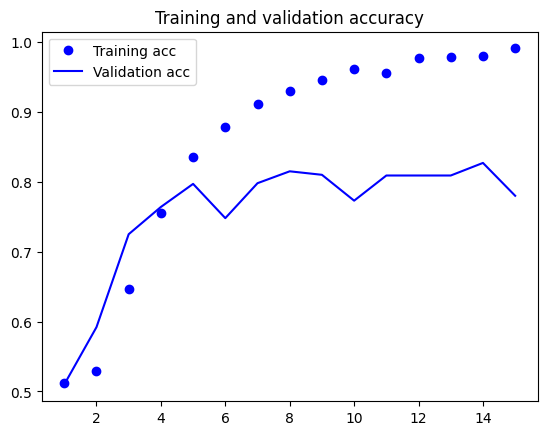

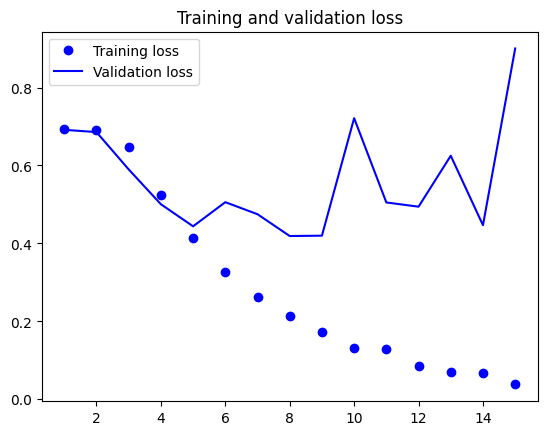

In [24]:
import matplotlib.pyplot as plt

acc = history.history["acc"] # Training accuracy
val_acc = history.history["val_acc"] # Validation accuracy
loss = history.history["loss"] # Training loss
val_loss = history.history["val_loss"] # Validation loss

epochs = range(1, len(acc) + 1) #plots every epoch, here 10

plt.plot(epochs, acc, "bo", label = "Training acc") # "bo" gives dot plot
plt.plot(epochs, val_acc, "b", label = "Validation acc") # "b" gives line plot
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [9]:
test_model = load_model('model1.h5')
Model1_Results = test_model.evaluate(test_texts,test_labels)
print(f'Loss: {Model1_Results[0]:.3f}')
print(f'Accuracy: {Model1_Results[1]:.3f}')

157/157 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5142
Loss: 0.692
Accuracy: 0.514


In [10]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  11.5M      0  0:00:06  0:00:06 --:--:-- 12.3M


In [11]:
!rm -r aclImdb/train/unsup

Using Pretrained Word Embeddings

In [12]:
imdb_dir = '/content/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
print('No. of Samples', len(texts))

No. of Samples 25000


Tokenizing the data

In [13]:
maxlen = 150  # cutting off reviews after 150 words
training_samples = 100  # training on 100 samples
validation_samples = 10000  # validating on 10000 samples
max_words = 10000  # considering the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splitting the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]


test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)[:5000]
y_test = np.asarray(labels)[:5000]

Found 88582 unique tokens.
Shape of data tensor: (25000, 150)
Shape of label tensor: (25000,)


In [14]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2024-11-22 03:39:41--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-22 03:39:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-22 03:39:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Using the GloVe word Embedding

In [15]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"


Preparing the GloVe word embeddings Matrix

In [16]:
embedding_dim = 100

# Build index mapping words in the embeddings set
# to their embedding vector.
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# Prepare embedding matrix
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Model Definition
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.summary()

# loading pretrained word embedding to Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Training and Evaluating Model
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",  # for multiclass use categorical_crossentropy
              metrics=["acc"])
history = model.fit(x_train, y_train,
                   epochs=15,
                   batch_size=32,
                   validation_data=(x_val, y_val))
model.save_weights("pre_trained_glove_model.h5")

Found 400000 word vectors.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 100)          1000000   
                                                                 
 flatten_1 (Flatten)         (None, 15000)             0         
                                                                 
 dense_1 (Dense)             (None, 32)                480032    
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,480,065
Trainable params: 1,480,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
4/4 [==============================] - 2s 413ms/step - loss: 1.4357 - acc: 0.5300 - val_loss: 0.6922 - val_acc: 0.5321
Epoch 2/15
4/4 [===

Plotting the Results

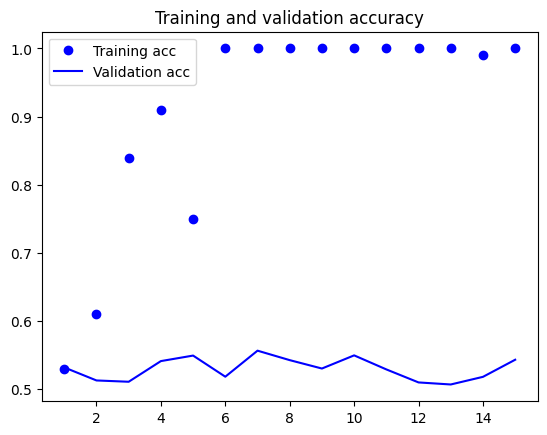

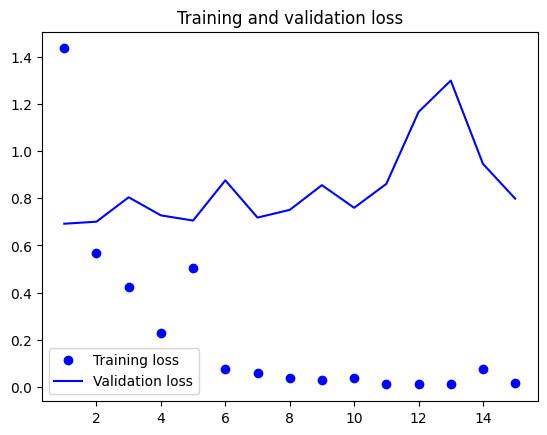

In [17]:
import matplotlib.pyplot as plt

acc = history.history["acc"] # Training accuracy
val_acc = history.history["val_acc"] # Validation accuracy
loss = history.history["loss"] # Training loss
val_loss = history.history["val_loss"] # Validation loss

epochs = range(1, len(acc) + 1) #plots every epoch, here 10

plt.plot(epochs, acc, "bo", label = "Training acc") # "bo" for dot plot
plt.plot(epochs, val_acc, "b", label = "Validation acc") # "b" for line plot
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()


In [19]:
!pip install keras_preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.6 MB/s eta 0:00:00


Preparing the IMDB dataset

In [21]:
from keras.datasets import imdb
# from keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_features = 10000 # Consider as features CUTTING THIS DOWN TO 1000 FROM 10.000!!!
maxlen = 150 # cuts off the text 'max_features' CUT FROM 500 TO 100 !!!
batch_size = 32

print ("loading data ...")
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words = max_features)

input_train = input_train[:5000]
y_train = y_train[:5000]
input_test = input_test[:5000]
y_test = y_test[:5000]

print(len(input_train), "train sequences")
print(len(input_test), "test sequences")


print("Pad sequences (samples x time)")
input_train = pad_sequences(input_train, maxlen=maxlen)
print("input_train shape:", input_train.shape)
print("input_test shape:", input_test.shape)

loading data ...
5000 train sequences
5000 test sequences
Pad sequences (samples x time)
input_train shape: (5000, 150)
input_test shape: (5000,)


In [22]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Flatten, Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = "rmsprop",
             loss = "binary_crossentropy",
             metrics = ["acc"])
history = model.fit(input_train, y_train, epochs=15, batch_size=128, validation_split=0.2)

Epoch 1/15
32/32 [==============================] - 6s 121ms/step - loss: 0.6929 - acc: 0.5120 - val_loss: 0.6916 - val_acc: 0.5100
Epoch 2/15
32/32 [==============================] - 3s 107ms/step - loss: 0.6900 - acc: 0.5297 - val_loss: 0.6857 - val_acc: 0.5920
Epoch 3/15
32/32 [==============================] - 5s 171ms/step - loss: 0.6472 - acc: 0.6467 - val_loss: 0.5899 - val_acc: 0.7250
Epoch 4/15
32/32 [==============================] - 6s 191ms/step - loss: 0.5253 - acc: 0.7548 - val_loss: 0.5006 - val_acc: 0.7640
Epoch 5/15
32/32 [==============================] - 4s 133ms/step - loss: 0.4143 - acc: 0.8353 - val_loss: 0.4439 - val_acc: 0.7970
Epoch 6/15
32/32 [==============================] - 3s 107ms/step - loss: 0.3257 - acc: 0.8790 - val_loss: 0.5059 - val_acc: 0.7480
Epoch 7/15
32/32 [==============================] - 3s 107ms/step - loss: 0.2635 - acc: 0.9115 - val_loss: 0.4750 - val_acc: 0.7980
Epoch 8/15
32/32 [==============================] - 6s 186ms/step - loss: 0.

In the smaller datasets the LSTM model runs well.

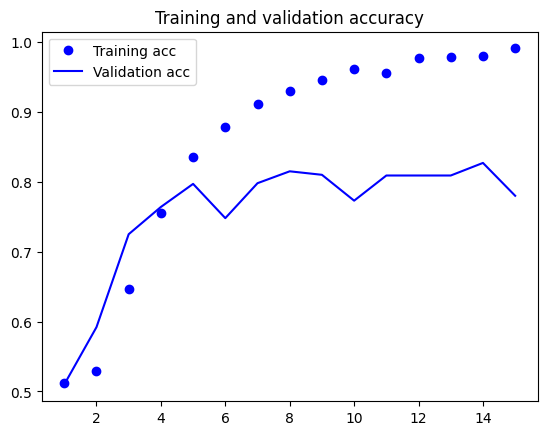

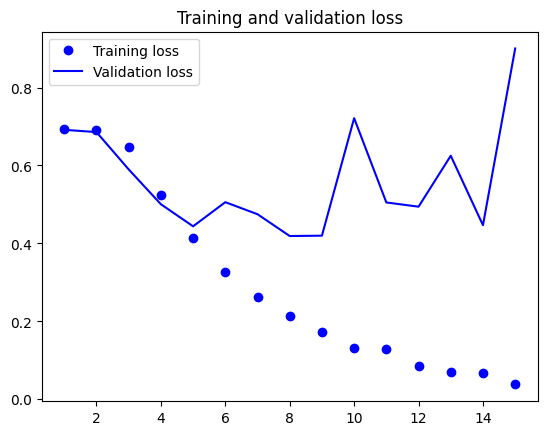

In [23]:
import matplotlib.pyplot as plt

acc = history.history["acc"] # Training accuracy
val_acc = history.history["val_acc"] # Validation accuracy
loss = history.history["loss"] # Training loss
val_loss = history.history["val_loss"] # Validation loss

epochs = range(1, len(acc) + 1) #plots every epoch, here 10

plt.plot(epochs, acc, "bo", label = "Training acc") # "bo" for dot plot
plt.plot(epochs, val_acc, "b", label = "Validation acc") # "b" for line plot
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()